# Building a Simple Bot with the Rasa Stack
![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTaX3LNhGcAe1HnPZSuWS0oH6af0LJHXcH7If1sQgLCFAT1chNGFg)


### Please make a copy of this notebook first!

If you're interested in building chatbots or voice apps with the [Rasa Stack](https://https://rasa.com/products/rasa-stack/), you've come to the right place! 
In this notebook you'll build a complete chatbot with Rasa Stack, without having to install anything on your computer. 

Using Colaboratory, everything will get installed in a cloud machine for you, so you can focus on creating an interesting bot. 

We'll build a relatively simple bot, that just asks you about your mood and tries to cheer you up if you're feeling a bit down. 

The tutorial consists of three parts:



*   Part 1: We'll start with a basic bot that can handle multi-turn dialogues but not understand natural language like "I'm doing well"
*   Part 2: We'll add the abilitiy to understand natural language so that the bot can generalise to similar inputs that it hasn't seen before
*   Part 3: We'll give you further resources so you can build your own.





# Part 1: Build a basic bot

### Installation
First we'll have to install Rasa Core on the server running this notebook. In this first step, your bot won't understand natural language yet. This happens in Step 2. **Run the cell below, this will take a couple of minutes to complete so this is a good time to scroll through the rest of the notebook.**

In [0]:
!pip install rasa_core;
!echo "Europe/Berlin" > /etc/timezone

import logging, io, json, warnings
logging.basicConfig(level="INFO")
warnings.filterwarnings('ignore')

    100% |████████████████████████████████| 81kB 2.3MB/s 
    100% |████████████████████████████████| 61kB 3.6MB/s 
    100% |████████████████████████████████| 51kB 3.3MB/s 
    100% |████████████████████████████████| 92kB 4.5MB/s 
    100% |████████████████████████████████| 71kB 5.6MB/s 
    100% |████████████████████████████████| 491kB 1.6MB/s 
    100% |████████████████████████████████| 307kB 2.4MB/s 
    100% |████████████████████████████████| 61kB 6.6MB/s 
    100% |████████████████████████████████| 71kB 6.0MB/s 
    100% |████████████████████████████████| 563kB 2.1MB/s 
    100% |████████████████████████████████| 61kB 8.8MB/s 


    100% |████████████████████████████████| 71kB 7.4MB/s 
    100% |████████████████████████████████| 71kB 7.3MB/s 
    100% |████████████████████████████████| 51kB 4.0MB/s 
    100% |████████████████████████████████| 1.9MB 614kB/s 
    100% |████████████████████████████████| 552kB 1.7MB/s 
    100% |████████████████████████████████| 133kB 5.6MB/s 
    100% |████████████████████████████████| 1.7MB 730kB/s 
    100% |████████████████████████████████| 51kB 8.6MB/s 
    100% |████████████████████████████████| 81kB 8.0MB/s 
    100% |████████████████████████████████| 204kB 4.8MB/s 


    100% |████████████████████████████████| 71kB 9.1MB/s 
    100% |████████████████████████████████| 6.8MB 196kB/s 
    100% |████████████████████████████████| 4.1MB 332kB/s 
    100% |████████████████████████████████| 61kB 7.8MB/s 
    100% |████████████████████████████████| 51kB 6.8MB/s 
    100% |████████████████████████████████| 3.0MB 435kB/s 
    100% |████████████████████████████████| 174kB 5.2MB/s 
  Running setup.py bdist_wheel for rasa-core ... - \

 done
  Stored in directory: /content/.cache/pip/wheels/08/77/de/5182477b39c19ded7746b53021d11b385a7efbc7c785d12ff9
  Running setup.py bdist_wheel for ConfigArgParse ... - done
  Stored in directory: /content/.cache/pip/wheels/1a/22/25/7110415a17e75253b02ced21a4fa5d62695bfe5fd652d9e434
  Running setup.py bdist_wheel for jsonpickle ... - \ done
  Stored in directory: /content/.cache/pip/wheels/c8/c5/88/0975a9ef0ae87799d3a4ae54244ca8f76eaaf03395f48a5129
  Running setup.py bdist_wheel for pandoc ... - done
  Stored in directory: /content/.cache/pip/wheels/08/c5/30/55eda9e3884c232e85c413b551e8bade2700e92e4094531270
  Running setup.py bdist_wheel for rasa-nlu ... - \ done
  Stored in directory: /content/.cache/pip/wheels/99/9a/4b/1e5478155f2839c5ff2641347c81355e78074d402536609538
  Running setup.py bdist_wheel for slackclient ... - \ done
  Stored in directory: /content/.cache/pip/wheels/c5/fe/31/22e8e5251b033a02315dec64f7ebf12924d8db291ccb5d5e83
  Running setup.py bdist_w

### Writing Stories

A good place to start is by writing a few stories. These are example conversations that Rasa Core will learn from. 

The format works like this:

A story starts with `##` and you can give it a name. 
lines that start with `*` are messages sent by the user. Although you don't write the *actual* message, but rather the intent (and the entities) that represent what the user *means*. If you don't know about intents and entities, don't worry! We will talk about them more later. 
Lines that start with `-` are *actions* taken by your bot. In this case all of our actions are just messages sent back to the user, like `utter_greet`, but in general an action can do anything, including calling an API and interacting with the outside world. 

In [0]:
stories_md = """
## happy path               <!-- name of the story - just for debugging -->
* greet              
  - utter_greet
* mood_great               <!-- user utterance, in format intent[entities] -->
  - utter_happy
* mood_affirm
  - utter_happy
* mood_affirm
  - utter_goodbye
  
  
## sad path 1               <!-- this is already the start of the next story -->
* greet
  - utter_greet             <!-- action the bot should execute -->
* mood_unhappy
  - utter_cheer_up
  - utter_did_that_help
* mood_affirm
  - utter_happy
  
  

## sad path 2
* greet
  - utter_greet
* mood_unhappy
  - utter_cheer_up
  - utter_did_that_help
* mood_deny
  - utter_goodbye
  
## strange user
* mood_affirm
  - utter_happy
* mood_affirm
  - utter_unclear

## say goodbye
* goodbye
  - utter_goodbye
  - utter_goodday
  



"""

%store stories_md > stories.md

Writing 'stories_md' (str) to file 'stories.md'.


### Defining a Domain

The domain specifies the universe that your bot lives in. You should list all of the intents and actions that show up in your stories. 
This is also the place to write templates, which contain the messages your bot can send back

In [0]:
domain_yml = """
intents:
  - greet
  - goodbye
  - mood_affirm
  - mood_deny
  - mood_great
  - mood_unhappy

actions:
- utter_greet
- utter_cheer_up
- utter_did_that_help
- utter_happy
- utter_goodbye
- utter_unclear

templates:
  utter_greet:
  - text: "Hey! How are you?"

  utter_cheer_up:
  - text: "Here is something to cheer you up:"
    image: "https://i.imgur.com/nGF1K8f.jpg"

  utter_did_that_help:
  - text: "Did that help you?"

  utter_unclear:
  - text: "I am not sure what you are aiming for."
  
  utter_happy:
  - text: "Great carry on!"

  utter_goodbye:
  - text: "Bye"
"""

%store domain_yml > domain.yml

Writing 'domain_yml' (str) to file 'domain.yml'.


### Training your Dialogue Model

Now comes the fun part! We're going to show Rasa Core the stories we wrote above, and train a model on these examples. 
In this case, the model is a neural network implemented in Keras which learns to predict which action to take next. 

In [0]:
from rasa_core.policies.keras_policy import KerasPolicy
from rasa_core.agent import Agent

agent = Agent('domain.yml', policies=[KerasPolicy()])
training_data = agent.load('stories.md')
agent.train(
        training_data,
        validation_split=0.0,
        epochs=400
)

agent.persist('models/dialogue')

INFO:apscheduler.scheduler:Scheduler started
Using TensorFlow backend.
Processed Story Blocks: 100%|██████████| 5/5 [00:00<00:00, 119.84it/s, # trackers=9, samples=352]
INFO:rasa_core.policies.keras_policy:Fitting model with 52 total samples and a validation split of 0.0


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 3, 14)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                6016      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
_________________________________________________________________
activation_1 (Activation)    (None, 8)                 0         
Total params: 6,280
Trainable params: 6,280
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
52/52 [==============================] - 0s 8ms/step - loss: 2.0419 - acc: 0.1923
Epoch 2/400
52/52 [==============================] - 0s 315us/step - loss: 2.0149 - acc: 0.4423
Epoch 3/400
52/52 [==============================] - 0s 332us/step - loss: 1.9888 

52/52 [==============================] - 0s 303us/step - loss: 1.7048 - acc: 0.5000
Epoch 23/400
52/52 [==============================] - 0s 352us/step - loss: 1.6523 - acc: 0.5000
Epoch 24/400
52/52 [==============================] - 0s 332us/step - loss: 1.6404 - acc: 0.5000
Epoch 25/400
52/52 [==============================] - 0s 326us/step - loss: 1.6405 - acc: 0.5000
Epoch 26/400
52/52 [==============================] - 0s 297us/step - loss: 1.6256 - acc: 0.5000
Epoch 27/400
52/52 [==============================] - 0s 306us/step - loss: 1.6135 - acc: 0.5000
Epoch 28/400
52/52 [==============================] - 0s 365us/step - loss: 1.5644 - acc: 0.5000
Epoch 29/400
52/52 [==============================] - 0s 400us/step - loss: 1.5636 - acc: 0.5000
Epoch 30/400
52/52 [==============================] - 0s 364us/step - loss: 1.5684 - acc: 0.5000
Epoch 31/400
52/52 [==============================] - 0s 374us/step - loss: 1.5275 - acc: 0.5000
Epoch 32/400
52/52 [=======================

52/52 [==============================] - 0s 357us/step - loss: 1.4008 - acc: 0.5000
Epoch 48/400
52/52 [==============================] - 0s 384us/step - loss: 1.3944 - acc: 0.5000
Epoch 49/400
52/52 [==============================] - 0s 377us/step - loss: 1.3984 - acc: 0.5000
Epoch 50/400
52/52 [==============================] - 0s 372us/step - loss: 1.3697 - acc: 0.5000
Epoch 51/400
52/52 [==============================] - 0s 394us/step - loss: 1.3803 - acc: 0.5000
Epoch 52/400
52/52 [==============================] - 0s 295us/step - loss: 1.3396 - acc: 0.5000
Epoch 53/400
52/52 [==============================] - 0s 328us/step - loss: 1.3548 - acc: 0.5000
Epoch 54/400
52/52 [==============================] - 0s 528us/step - loss: 1.3596 - acc: 0.5000
Epoch 55/400
52/52 [==============================] - 0s 401us/step - loss: 1.3582 - acc: 0.5000
Epoch 56/400
52/52 [==============================] - 0s 366us/step - loss: 1.3469 - acc: 0.5000
Epoch 57/400
52/52 [=======================

Epoch 72/400
52/52 [==============================] - 0s 269us/step - loss: 1.2638 - acc: 0.5000
Epoch 73/400
52/52 [==============================] - 0s 408us/step - loss: 1.2407 - acc: 0.5000
Epoch 74/400
52/52 [==============================] - 0s 397us/step - loss: 1.2111 - acc: 0.5000
Epoch 75/400
52/52 [==============================] - 0s 336us/step - loss: 1.2140 - acc: 0.5000
Epoch 76/400
52/52 [==============================] - 0s 349us/step - loss: 1.1866 - acc: 0.5000
Epoch 77/400
52/52 [==============================] - 0s 383us/step - loss: 1.2631 - acc: 0.5000
Epoch 78/400
52/52 [==============================] - 0s 351us/step - loss: 1.2113 - acc: 0.5000
Epoch 79/400
52/52 [==============================] - 0s 365us/step - loss: 1.1994 - acc: 0.5000
Epoch 80/400
52/52 [==============================] - 0s 268us/step - loss: 1.1646 - acc: 0.5000
Epoch 81/400
52/52 [==============================] - 0s 370us/step - loss: 1.1750 - acc: 0.5000
Epoch 82/400
52/52 [==========

52/52 [==============================] - 0s 413us/step - loss: 1.1599 - acc: 0.5385
Epoch 98/400
52/52 [==============================] - 0s 407us/step - loss: 1.0819 - acc: 0.5577
Epoch 99/400
52/52 [==============================] - 0s 395us/step - loss: 1.0642 - acc: 0.5577
Epoch 100/400
52/52 [==============================] - 0s 409us/step - loss: 1.0290 - acc: 0.5769
Epoch 101/400
52/52 [==============================] - 0s 443us/step - loss: 1.0190 - acc: 0.5962
Epoch 102/400
52/52 [==============================] - 0s 308us/step - loss: 1.0897 - acc: 0.5192
Epoch 103/400
52/52 [==============================] - 0s 413us/step - loss: 1.0321 - acc: 0.5962
Epoch 104/400
52/52 [==============================] - 0s 315us/step - loss: 1.0250 - acc: 0.6538
Epoch 105/400
52/52 [==============================] - 0s 428us/step - loss: 1.0020 - acc: 0.6154
Epoch 106/400
52/52 [==============================] - 0s 479us/step - loss: 1.0679 - acc: 0.5385
Epoch 107/400
52/52 [===============

Epoch 123/400
52/52 [==============================] - 0s 286us/step - loss: 0.8528 - acc: 0.7885
Epoch 124/400
52/52 [==============================] - 0s 418us/step - loss: 0.8748 - acc: 0.8077
Epoch 125/400
52/52 [==============================] - 0s 383us/step - loss: 0.8728 - acc: 0.7308
Epoch 126/400
52/52 [==============================] - 0s 393us/step - loss: 0.8113 - acc: 0.7885
Epoch 127/400
52/52 [==============================] - 0s 471us/step - loss: 0.8099 - acc: 0.8269
Epoch 128/400
52/52 [==============================] - 0s 392us/step - loss: 0.8354 - acc: 0.7308
Epoch 129/400
52/52 [==============================] - 0s 343us/step - loss: 0.7944 - acc: 0.8269
Epoch 130/400
52/52 [==============================] - 0s 387us/step - loss: 0.7638 - acc: 0.8654
Epoch 131/400
52/52 [==============================] - 0s 378us/step - loss: 0.8105 - acc: 0.7692
Epoch 132/400
52/52 [==============================] - 0s 373us/step - loss: 0.8387 - acc: 0.7692
Epoch 133/400
52/52 

52/52 [==============================] - 0s 377us/step - loss: 0.6571 - acc: 0.9038
Epoch 149/400
52/52 [==============================] - 0s 328us/step - loss: 0.6877 - acc: 0.8462
Epoch 150/400
52/52 [==============================] - 0s 377us/step - loss: 0.6680 - acc: 0.8269
Epoch 151/400
52/52 [==============================] - 0s 436us/step - loss: 0.6406 - acc: 0.8654
Epoch 152/400
52/52 [==============================] - 0s 333us/step - loss: 0.6351 - acc: 0.9038
Epoch 153/400
52/52 [==============================] - 0s 387us/step - loss: 0.6148 - acc: 0.8654
Epoch 154/400
52/52 [==============================] - 0s 507us/step - loss: 0.6807 - acc: 0.7885
Epoch 155/400
52/52 [==============================] - 0s 445us/step - loss: 0.6800 - acc: 0.7885
Epoch 156/400
52/52 [==============================] - 0s 327us/step - loss: 0.6983 - acc: 0.8269
Epoch 157/400
52/52 [==============================] - 0s 403us/step - loss: 0.5933 - acc: 0.8846
Epoch 158/400
52/52 [=============


52/52 [==============================] - 0s 321us/step - loss: 0.5520 - acc: 0.8846
Epoch 175/400
52/52 [==============================] - 0s 364us/step - loss: 0.5055 - acc: 0.9038
Epoch 176/400
52/52 [==============================] - 0s 361us/step - loss: 0.5344 - acc: 0.8462
Epoch 177/400
52/52 [==============================] - 0s 335us/step - loss: 0.5189 - acc: 0.8846
Epoch 178/400
52/52 [==============================] - 0s 347us/step - loss: 0.4975 - acc: 0.9038
Epoch 179/400
52/52 [==============================] - 0s 359us/step - loss: 0.4615 - acc: 0.9231
Epoch 180/400
52/52 [==============================] - 0s 391us/step - loss: 0.5333 - acc: 0.8846
Epoch 181/400
52/52 [==============================] - 0s 356us/step - loss: 0.5368 - acc: 0.8654
Epoch 182/400
52/52 [==============================] - 0s 448us/step - loss: 0.5073 - acc: 0.8654
Epoch 183/400
52/52 [==============================] - 0s 519us/step - loss: 0.5107 - acc: 0.9038
Epoch 184/400
52/52 [============

52/52 [==============================] - 0s 373us/step - loss: 0.4832 - acc: 0.8654
Epoch 201/400
52/52 [==============================] - 0s 376us/step - loss: 0.4800 - acc: 0.8846
Epoch 202/400
52/52 [==============================] - 0s 355us/step - loss: 0.4346 - acc: 0.9038
Epoch 203/400
52/52 [==============================] - 0s 458us/step - loss: 0.4288 - acc: 0.9038
Epoch 204/400
52/52 [==============================] - 0s 384us/step - loss: 0.4599 - acc: 0.9231
Epoch 205/400
52/52 [==============================] - 0s 340us/step - loss: 0.4119 - acc: 0.9038
Epoch 206/400
52/52 [==============================] - 0s 284us/step - loss: 0.4151 - acc: 0.9038
Epoch 207/400
52/52 [==============================] - 0s 296us/step - loss: 0.4045 - acc: 0.9231
Epoch 208/400
52/52 [==============================] - 0s 288us/step - loss: 0.4450 - acc: 0.9038
Epoch 209/400
52/52 [==============================] - 0s 267us/step - loss: 0.4312 - acc: 0.9423
Epoch 210/400
52/52 [=============

52/52 [==============================] - 0s 414us/step - loss: 0.4195 - acc: 0.9038
Epoch 226/400
52/52 [==============================] - 0s 272us/step - loss: 0.4880 - acc: 0.8269
Epoch 227/400
52/52 [==============================] - 0s 275us/step - loss: 0.3741 - acc: 0.9423
Epoch 228/400
52/52 [==============================] - 0s 309us/step - loss: 0.3905 - acc: 0.9038
Epoch 229/400
52/52 [==============================] - 0s 351us/step - loss: 0.3935 - acc: 0.9615
Epoch 230/400
52/52 [==============================] - 0s 253us/step - loss: 0.3631 - acc: 0.9038
Epoch 231/400
52/52 [==============================] - 0s 335us/step - loss: 0.3568 - acc: 0.9038
Epoch 232/400
52/52 [==============================] - 0s 456us/step - loss: 0.3778 - acc: 0.8846
Epoch 233/400
52/52 [==============================] - 0s 334us/step - loss: 0.3543 - acc: 0.9038
Epoch 234/400
52/52 [==============================] - 0s 471us/step - loss: 0.3859 - acc: 0.8654
Epoch 235/400
52/52 [=============

Epoch 252/400
52/52 [==============================] - 0s 404us/step - loss: 0.3181 - acc: 0.9231
Epoch 253/400
52/52 [==============================] - 0s 295us/step - loss: 0.3330 - acc: 0.9231
Epoch 254/400
52/52 [==============================] - 0s 338us/step - loss: 0.2597 - acc: 0.9615
Epoch 255/400
52/52 [==============================] - 0s 302us/step - loss: 0.3146 - acc: 0.9423
Epoch 256/400
52/52 [==============================] - 0s 298us/step - loss: 0.3031 - acc: 0.9423
Epoch 257/400
52/52 [==============================] - 0s 362us/step - loss: 0.3262 - acc: 0.9615
Epoch 258/400
52/52 [==============================] - 0s 287us/step - loss: 0.2806 - acc: 0.9615
Epoch 259/400
52/52 [==============================] - 0s 295us/step - loss: 0.2925 - acc: 0.9231
Epoch 260/400
52/52 [==============================] - 0s 341us/step - loss: 0.3164 - acc: 0.9423
Epoch 261/400
52/52 [==============================] - 0s 344us/step - loss: 0.2743 - acc: 0.9615
Epoch 262/400
52/52 

Epoch 279/400
52/52 [==============================] - 0s 306us/step - loss: 0.2338 - acc: 0.9615
Epoch 280/400
52/52 [==============================] - 0s 302us/step - loss: 0.3380 - acc: 0.9231
Epoch 281/400
52/52 [==============================] - 0s 392us/step - loss: 0.2848 - acc: 0.9231
Epoch 282/400
52/52 [==============================] - 0s 324us/step - loss: 0.2434 - acc: 0.9423
Epoch 283/400
52/52 [==============================] - 0s 416us/step - loss: 0.2550 - acc: 0.9423
Epoch 284/400
52/52 [==============================] - 0s 346us/step - loss: 0.2347 - acc: 0.9615
Epoch 285/400
52/52 [==============================] - 0s 299us/step - loss: 0.2401 - acc: 0.9615
Epoch 286/400
52/52 [==============================] - 0s 390us/step - loss: 0.2614 - acc: 0.9231
Epoch 287/400
52/52 [==============================] - 0s 400us/step - loss: 0.2217 - acc: 0.9423
Epoch 288/400
52/52 [==============================] - 0s 304us/step - loss: 0.2581 - acc: 0.9231
Epoch 289/400
52/52 

52/52 [==============================] - 0s 324us/step - loss: 0.2547 - acc: 0.9231
Epoch 307/400
52/52 [==============================] - 0s 306us/step - loss: 0.2526 - acc: 0.9231
Epoch 308/400
52/52 [==============================] - 0s 388us/step - loss: 0.2814 - acc: 0.9038
Epoch 309/400
52/52 [==============================] - 0s 272us/step - loss: 0.1983 - acc: 0.9615
Epoch 310/400
52/52 [==============================] - 0s 271us/step - loss: 0.2384 - acc: 0.9423
Epoch 311/400
52/52 [==============================] - 0s 365us/step - loss: 0.2502 - acc: 0.9231
Epoch 312/400
52/52 [==============================] - 0s 282us/step - loss: 0.2809 - acc: 0.9231
Epoch 313/400
52/52 [==============================] - 0s 295us/step - loss: 0.2485 - acc: 0.9231
Epoch 314/400
52/52 [==============================] - 0s 283us/step - loss: 0.2312 - acc: 0.9423
Epoch 315/400
52/52 [==============================] - 0s 409us/step - loss: 0.2105 - acc: 0.9231
Epoch 316/400
52/52 [=============

52/52 [==============================] - 0s 320us/step - loss: 0.2093 - acc: 0.9231
Epoch 333/400
52/52 [==============================] - 0s 322us/step - loss: 0.2371 - acc: 0.9231
Epoch 334/400
52/52 [==============================] - 0s 330us/step - loss: 0.2404 - acc: 0.9423
Epoch 335/400
52/52 [==============================] - 0s 305us/step - loss: 0.1868 - acc: 0.9615
Epoch 336/400
52/52 [==============================] - 0s 307us/step - loss: 0.2377 - acc: 0.9423
Epoch 337/400
52/52 [==============================] - 0s 362us/step - loss: 0.2206 - acc: 0.9231
Epoch 338/400
52/52 [==============================] - 0s 374us/step - loss: 0.2095 - acc: 0.9231
Epoch 339/400
52/52 [==============================] - 0s 341us/step - loss: 0.1706 - acc: 0.9615
Epoch 340/400
52/52 [==============================] - 0s 334us/step - loss: 0.2865 - acc: 0.8846
Epoch 341/400
52/52 [==============================] - 0s 304us/step - loss: 0.2073 - acc: 0.9231
Epoch 342/400
52/52 [=============

Epoch 357/400
52/52 [==============================] - 0s 375us/step - loss: 0.1930 - acc: 0.9231
Epoch 358/400
52/52 [==============================] - 0s 331us/step - loss: 0.1896 - acc: 0.9423
Epoch 359/400
52/52 [==============================] - 0s 259us/step - loss: 0.2411 - acc: 0.9423
Epoch 360/400
52/52 [==============================] - 0s 425us/step - loss: 0.2010 - acc: 0.9615
Epoch 361/400
52/52 [==============================] - 0s 384us/step - loss: 0.3112 - acc: 0.8654
Epoch 362/400
52/52 [==============================] - 0s 337us/step - loss: 0.1950 - acc: 0.9038
Epoch 363/400
52/52 [==============================] - 0s 366us/step - loss: 0.1760 - acc: 0.9423
Epoch 364/400
52/52 [==============================] - 0s 388us/step - loss: 0.2134 - acc: 0.9231
Epoch 365/400
52/52 [==============================] - 0s 301us/step - loss: 0.2468 - acc: 0.9231
Epoch 366/400
52/52 [==============================] - 0s 329us/step - loss: 0.1480 - acc: 0.9615
Epoch 367/400
52/52 

Epoch 383/400
52/52 [==============================] - 0s 327us/step - loss: 0.1586 - acc: 0.9615
Epoch 384/400
52/52 [==============================] - 0s 345us/step - loss: 0.1527 - acc: 0.9615
Epoch 385/400
52/52 [==============================] - 0s 409us/step - loss: 0.1892 - acc: 0.9231
Epoch 386/400
52/52 [==============================] - 0s 345us/step - loss: 0.2017 - acc: 0.9423
Epoch 387/400
52/52 [==============================] - 0s 391us/step - loss: 0.2050 - acc: 0.9231
Epoch 388/400
52/52 [==============================] - 0s 318us/step - loss: 0.1739 - acc: 0.9231
Epoch 389/400
52/52 [==============================] - 0s 338us/step - loss: 0.2215 - acc: 0.9231
Epoch 390/400
52/52 [==============================] - 0s 498us/step - loss: 0.1839 - acc: 0.9423
Epoch 391/400
52/52 [==============================] - 0s 308us/step - loss: 0.1946 - acc: 0.9615
Epoch 392/400
52/52 [==============================] - 0s 348us/step - loss: 0.1698 - acc: 0.9423
Epoch 393/400
52/52 

INFO:rasa_core.policies.keras_policy:Done fitting keras policy model
INFO:rasa_core.agent:Persisted model to '/content/models/dialogue'


### Starting up the bot
Lets start up the bot!


In [0]:
from rasa_core.agent import Agent
agent = Agent.load('models/dialogue')

### Talking to the bot (no NLU)

In this step, we just trained the dialogue model - so basically the conversational flow. So the bot will only understand **structured** input and **no** natural language yet. Go try it out with typing  "/" + one of the intents from your domain before, e.g.:

/greet

/mood_affirm

/mood_deny

In [0]:
print("Your bot is ready to talk! Type your messages here or send 'stop'")
while True:
    a = input()
    if a == 'stop':
        break
    responses = agent.handle_message(a)
    for response in responses:
        print(response)

Your bot is ready to talk! Type your messages here or send 'stop'


# Part 2: Add natural language understanding

So far, our bot doesn't understand regular sentences with natural language yet.
To do that, we're going to build a language understanding model with Rasa NLU. 

### Installing NLU
We have to install a couple of more things in this notebook here. **Run the cell below** - in the meantime, you can check out the rest of the code.


In [0]:
!apt-get -qq install -y graphviz libgraphviz-dev pkg-config && pip install pygraphviz;
!pip install rasa_nlu;
!pip install spacy;
!python -m spacy download en;

Extracting templates from packages: 100%
Selecting previously unselected package fontconfig.
(Reading database ... 16712 files and directories currently installed.)
Preparing to unpack .../00-fontconfig_2.11.94-0ubuntu2_amd64.deb ...
Unpacking fontconfig (2.11.94-0ubuntu2) ...
Selecting previously unselected package libxinerama1:amd64.
Preparing to unpack .../01-libxinerama1_2%3a1.1.3-1_amd64.deb ...
Unpacking libxinerama1:amd64 (2:1.1.3-1) ...
Selecting previously unselected package libjbig0:amd64.
Preparing to unpack .../02-libjbig0_2.1-3.1_amd64.deb ...
Unpacking libjbig0:amd64 (2.1-3.1) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../03-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../04-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected

Selecting previously unselected package librsvg2-common:amd64.
Preparing to unpack .../29-librsvg2-common_2.40.18-1_amd64.deb ...
Unpacking librsvg2-common:amd64 (2.40.18-1) ...
Selecting previously unselected package humanity-icon-theme.
Preparing to unpack .../30-humanity-icon-theme_0.6.13_all.deb ...
Unpacking humanity-icon-theme (0.6.13) ...
Selecting previously unselected package ubuntu-mono.
Preparing to unpack .../31-ubuntu-mono_16.10+17.10.20171115-0ubuntu1_all.deb ...
Unpacking ubuntu-mono (16.10+17.10.20171115-0ubuntu1) ...
Selecting previously unselected package adwaita-icon-theme.
Preparing to unpack .../32-adwaita-icon-theme_3.26.0-0ubuntu2_all.deb ...
Unpacking adwaita-icon-theme (3.26.0-0ubuntu2) ...
Selecting previously unselected package autotools-dev.
Preparing to unpack .../33-autotools-dev_20161112.1_all.deb ...
Unpacking autotools-dev (20161112.1) ...
Selecting previously unselected package libcdt5.
Preparing to unpack .../34-libcdt5_2.38.0-16ubuntu2_amd64.deb ...


Selecting previously unselected package libgail18:amd64.
Preparing to unpack .../61-libgail18_2.24.31-2ubuntu1_amd64.deb ...
Unpacking libgail18:amd64 (2.24.31-2ubuntu1) ...
Selecting previously unselected package libgail-common:amd64.
Preparing to unpack .../62-libgail-common_2.24.31-2ubuntu1_amd64.deb ...
Unpacking libgail-common:amd64 (2.24.31-2ubuntu1) ...
Selecting previously unselected package libgdk-pixbuf2.0-bin.
Preparing to unpack .../63-libgdk-pixbuf2.0-bin_2.36.11-1ubuntu0.1_amd64.deb ...
Unpacking libgdk-pixbuf2.0-bin (2.36.11-1ubuntu0.1) ...
Selecting previously unselected package libxdot4.
Preparing to unpack .../64-libxdot4_2.38.0-16ubuntu2_amd64.deb ...
Unpacking libxdot4 (2.38.0-16ubuntu2) ...
Selecting previously unselected package libgvc6-plugins-gtk.
Preparing to unpack .../65-libgvc6-plugins-gtk_2.38.0-16ubuntu2_amd64.deb ...
Unpacking libgvc6-plugins-gtk (2.38.0-16ubuntu2) ...
Selecting previously unselected package libltdl-dev:amd64.
Preparing to unpack .../66-l

Setting up libpangoft2-1.0-0:amd64 (1.40.12-1) ...
Setting up libavahi-client3:amd64 (0.6.32-1ubuntu1) ...
Setting up libcups2:amd64 (2.2.4-7ubuntu3) ...
Setting up libpangocairo-1.0-0:amd64 (1.40.12-1) ...
Setting up libgvc6 (2.38.0-16ubuntu2) ...
Setting up librsvg2-2:amd64 (2.40.18-1) ...
Setting up librsvg2-common:amd64 (2.40.18-1) ...
Setting up graphviz (2.38.0-16ubuntu2) ...
Setting up adwaita-icon-theme (3.26.0-0ubuntu2) ...
update-alternatives: using /usr/share/icons/Adwaita/cursor.theme to provide /usr/share/icons/default/index.theme (x-cursor-theme) in auto mode
Setting up libgtk2.0-0:amd64 (2.24.31-2ubuntu1) ...
Setting up libgail18:amd64 (2.24.31-2ubuntu1) ...
Setting up libgail-common:amd64 (2.24.31-2ubuntu1) ...
Setting up libgvc6-plugins-gtk (2.38.0-16ubuntu2) ...
Setting up humanity-icon-theme (0.6.13) ...
Setting up libgraphviz-dev (2.38.0-16ubuntu2) ...
Setting up libgtk2.0-bin (2.24.31-2ubuntu1) ...
Setting up ubuntu-mono (16.10+17.10.20171115-0ubuntu1) ...
Processi

    100% |████████████████████████████████| 17.5MB 75kB/s 
    100% |████████████████████████████████| 51kB 8.4MB/s 
    100% |████████████████████████████████| 890kB 1.4MB/s 
    100% |████████████████████████████████| 92kB 8.8MB/s 
    100% |████████████████████████████████| 604kB 2.0MB/s 
    100% |████████████████████████████████| 1.2MB 1.0MB/s 
    100% |████████████████████████████████| 194kB 5.9MB/s 
    100% |████████████████████████████████| 389kB 3.0MB/s 
    100% |████████████████████████████████| 51kB 4.9MB/s 
  Running setup.py bdist_wheel for spacy ... - \ | / - \ | / - \

 | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done
  Stored in directory: /content/.cache/pip/wheels/0a/7a/92/23f94d6a3e10192bdffa2d20836e28271801b459915c568049
  Running setup.py bdist_wheel for cymem ... - \ | done
  Stored in directory: /content/.cache/pip/wheels/4b/2a/0e/dce3ff7a6f0f916906ef978afe512a7b5aef8abfd9ba988acf
  Running setup.py bdist_wheel for ftfy ... - \ done
  Stored in directory: /content/.cache/pip/wheels/ae/d7/4c/339066248431397227741c7fdc80ad85826188ee9b0c24b4c7
  Running setup.py bdist_wheel for html5lib ... - \ done
  Stored in directory: /content/.cache/pip/wheels/d4/d1/0b/a6b6f9f204af55c9bb8c97eae2a78b690b7150a7b850bb9403
  Running setup.py bdist_wheel for msgpack-python ... - done
  Stored in directory: /content/.

  Running setup.py bdist_wheel for ujson ... - \ | / - \ done
  Stored in directory: /content/.cache/pip/wheels/9e/9b/d0/df92653bb5b2664c15d8ee5b99e3f2eb08a034444db8922b2f
  Running setup.py bdist_wheel for cytoolz ... - \ | - \ | / done
  Stored in directory: /content/.cache/pip/wheels/52/92/ed/661ecb7a67b42b21fc3dea140abb9ae9b8e94e72f0b3aff6c1
  Running setup.py bdist_wheel for wrapt ... - \ done
  Stored in directory: /content/.cache/pip/wheels/56/e1/0f/f7ccf1ed8ceaabccc2a93ce0481f73e589814cbbc439291345
  Running setup.py bdist_wheel for toolz ... - \ done
  Stored in directory: /content/.cache/pip/wheels/57/51/8a/433a9c0a2c65fc1b2a795ae036b932f3339a02e9ae88367659
Successfully built spacy cymem ftfy html5lib msgpack-python murmurhash preshed regex thinc ujson cytoolz wrapt toolz
  Found existing installation: html5lib 0.9999999
    Uninstalling html5lib-0.9999999:
      Successfully uninstalled html5lib-0.9999999
    100% |██████████████████████████

### Language Understanding


Lets create some training data here, grouping user messages by their `intent`s. The intent describes what the messages *mean*. 

In [0]:
nlu_md = """
## intent:greet
- hey
- hello
- hi
- hello there
- good morning
- good evening
- moin
- hey there
- let's go
- hey dude
- goodmorning
- goodevening
- good afternoon

## intent:goodbye
- cu
- good by
- cee you later
- good night
- good afternoon
- bye
- goodbye
- have a nice day
- see you around
- bye bye
- see you later

## intent:mood_affirm
- yes
- indeed
- of course
- that sounds good
- correct

## intent:mood_deny
- no
- never
- I don't think so
- don't like that
- no way
- not really

## intent:mood_great
- perfect
- very good
- great
- amazing
- feeling like a king
- wonderful
- I am feeling very good
- I am great
- I am amazing
- I am going to save the world
- super
- extremely good
- so so perfect
- so good
- so perfect

## intent:mood_unhappy
- my day was horrible
- I am sad
- I don't feel very well
- I am disappointed
- super sad
- I'm so sad
- sad
- very sad
- unhappy
- bad
- very bad
- awful
- terrible
- not so good
- not very good
- extremly sad
- so saad
- so sad
"""

%store nlu_md > nlu.md

Writing 'nlu_md' (str) to file 'nlu.md'.


### Train the Rasa NLU Model

We're going to train a model to recognise these intents, so that when we send a message like "hello" to our bot, it will recognise this as a "greet" intent.

In [0]:
from rasa_nlu.training_data import load_data
from rasa_nlu.config import RasaNLUModelConfig
from rasa_nlu.model import Trainer

training_data = load_data('nlu.md')
pipeline = [{"name": "nlp_spacy"}, 
            {"name": "tokenizer_spacy"}, 
            {"name": "intent_featurizer_spacy"},  
            {"name": "intent_classifier_sklearn"}]
trainer = Trainer(RasaNLUModelConfig({"pipeline": pipeline}))
interpreter = trainer.train(training_data)
model_directory = trainer.persist('./projects/default/')

INFO:rasa_nlu.converters:Training data format at nlu.md is md
INFO:rasa_nlu.training_data:Training data stats: 
	- intent examples: 68 (6 distinct intents)
	- found intents: 'goodbye', 'greet', 'mood_affirm', 'mood_deny', 'mood_great', 'mood_unhappy'
	- entity examples: 0 (0 distinct entities)
	- found entities: 

INFO:rasa_nlu.utils.spacy_utils:Trying to load spacy model with name 'en'
INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.
INFO:rasa_nlu.model:Starting to train component nlp_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component tokenizer_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component intent_featurizer_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component intent_classifier_sklearn
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
INFO:rasa_nlu.model:Finished training comp

Fitting 2 folds for each of 6 candidates, totalling 12 fits


### Starting up the bot (with NLU)

Now that we've trained the dialogue **and** language understanding models and saved them, we can start up an `Agent` which will handle conversations for us. 

In [0]:
from rasa_core.agent import Agent
agent = Agent.load('models/dialogue', interpreter=model_directory)

INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.


### Talking to the Bot (with NLU)

We can start talking to the bot in natural language.

In [0]:
print("Your bot is ready to talk! Type your messages here or send 'stop'")
while True:
    a = input()
    if a == 'stop':
        break
    responses = agent.handle_message(a)
    for response in responses:
        print(response)


Your bot is ready to talk! Type your messages here or send 'stop'
hey


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Hey! How are you?
I'm very sad


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Here is something to cheer you up:
Image: https://i.imgur.com/nGF1K8f.jpg
Did that help you?
/restart
hey


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Hey! How are you?
I'm very happy


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Here is something to cheer you up:
Image: https://i.imgur.com/nGF1K8f.jpg
Did that help you?


KeyboardInterrupt: ignored

### Pro Tip: Visualising the Training Data

You can visualise the stories to get a sense of how the conversations go. This is usually a good way to see if there are any stories which don't make sense


Processed Story Blocks: 100%|██████████| 5/5 [00:00<00:00, 14716.86it/s]


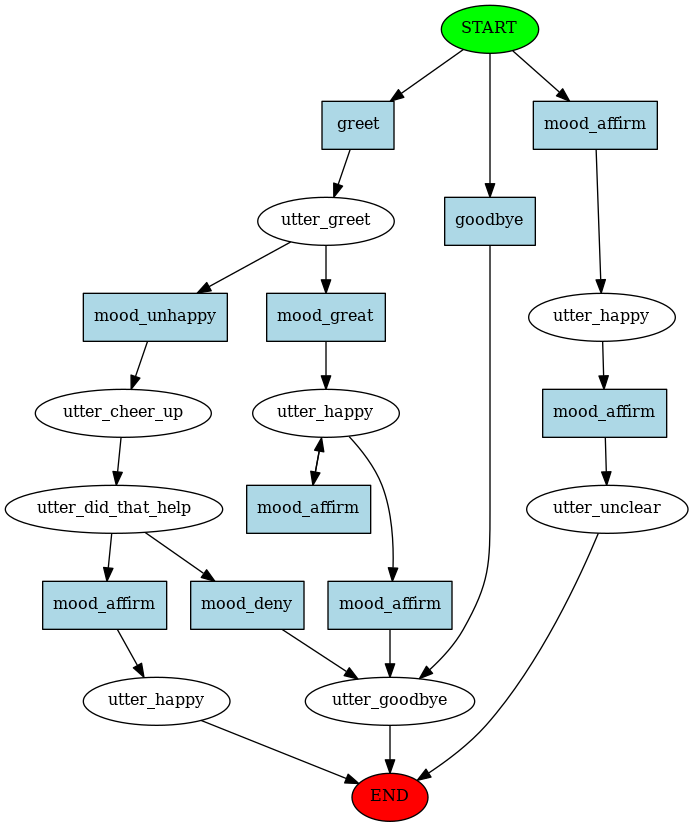

In [0]:
from rasa_core.agent import Agent
from IPython.display import Image

agent = Agent.load('models/dialogue')
agent.visualize("stories.md", "story_graph.png", max_history=2)
Image(filename="story_graph.png")

# Part 3: Next steps

Great job! You've built your first bot that uses Machine Learning to manage dialogues. As a next step, we'd suggest you start building your own bot. Here are a few useful links:



*   Install the Rasa Stack on your machine [here](https://core.rasa.ai/installation.html)
*   Learn how to bootstrap training data with the [interactive learning tutorial](https://core.rasa.ai/tutorial_interactive_learning.html)
*   Connect to the community in our [Gitter Chat](https://gitter.im/RasaHQ/rasa_core)



---




*Any feedback for this tutorial?* Please shoot us an email at hi@rasa.com